In [34]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE

from tqdm import tqdm

from types import SimpleNamespace
import os, sys


In [35]:

project_dir = './msn'

if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


FileNotFoundError: [Errno 2] No such file or directory: './msn'

In [36]:
model_folder = 'output/hpw1/proto10_embed32'


config_path = os.path.join( model_folder ,'config.yaml')

with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
        config = SimpleNamespace(**config_dict)

In [37]:
config

namespace(alpha_ema=0.996,
          attn_drop_rate=0.0,
          batch_size=512,
          bwpe=False,
          data_root='./../../hyperview1/resized_144/train/',
          depth=12,
          drop_path_rate=0.0,
          drop_rate=0.0,
          embed_dim=32,
          encoder_type='hsi',
          epoch_stop_prototype=100,
          final_lr=1e-06,
          final_weight_decay=0.05,
          focal_crop_scale=[0.5, 0.6],
          focal_size=[32, 32, 144],
          focal_views=5,
          in_chans=1,
          lambda_reg=0.5,
          learning_rate=0.001,
          mask_ratio=0.25,
          mlp_ratio=4.0,
          num_epochs=200,
          num_heads=4,
          num_prototipos=10,
          num_workers=8,
          output_dir='./output/hpw1/proto10_embed32',
          patch_size=[16, 16, 36],
          pin_memory=True,
          project_name='hsi-msn',
          rand_crop_scale=[0.8, 1.0],
          rand_size=[64, 64, 144],
          rand_views=5,
          resume_from=None,

## Load dataset

In [38]:
from src.dataset import init_data
from torch.utils.data import DataLoader


config_dict['shuffle'] = False

dataset = init_data(config_dict)


0it [00:00, ?it/s]

(512, 1, 64, 64, 64)


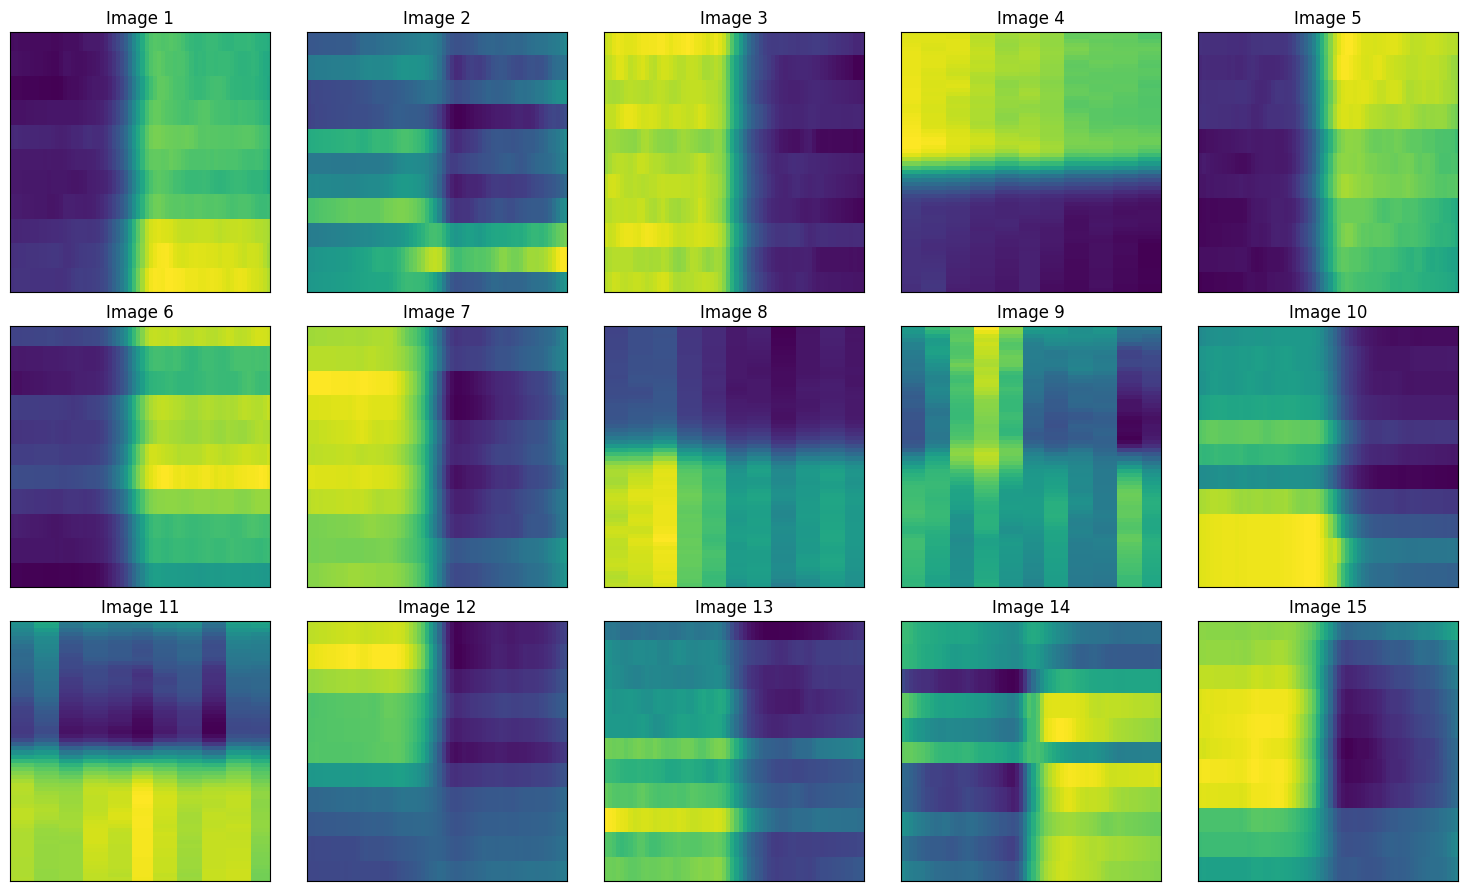

0it [00:12, ?it/s]


In [39]:
# the dataloader returns prisma_data, sentinel_data, airborne_data, 0

# plot 15 images from  airborne data  5x3 grid

#  withe theme

plt.style.use('default')


BAND_NUMBER = 2

for i, views in tqdm(enumerate(dataset)):
    views = [v for v in views]

     # shape [32, 1, 430, 20, 20] view[0] plot
     # view[0] to numpy

    view = views[0].detach().cpu().numpy()

    #plot
    print(view.shape)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    axs = axs.flatten()
    for j in range(15):
        axs[j].imshow(view[j,0, BAND_NUMBER, :, :])
        axs[j].set_title(f'Image {j+1}')
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.tight_layout()
    plt.show()

    break

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#device = "cpu"
from src.hsi_msn import MSNModel

model = MSNModel(config).to(device)


checkpoint_path = f"{config.output_dir}/min_loss_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])



Using Vision Transformer HSI as encoder.


<All keys matched successfully>

In [41]:
checkpoint["epoch"]

64

In [42]:
prot = model.prototypes
prot = prot.to(device)
prot = torch.nn.functional.normalize(prot, dim = 0 )
prot.shape

torch.Size([10, 32])

In [43]:
model.eval()

E = torch.empty(0, config.embed_dim).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


count = 0

with torch.no_grad():

    # 10% dos dados
    for i , views in tqdm(enumerate(dataset)):
        count += 1

         # shape [32, 1, 430, 20, 20] view[0] plot
         # view[0] to numpy

        views = views[0].to(device)
        z_views = model.target_encoder(views, mask_ratio=0.0   )

        z_views = torch.nn.functional.normalize(z_views, dim=1)

        E = torch.cat((E, z_views), 0)

        F = torch.cat((F, z_views @ prot.T), 0)

        # if count == 20:
        #     break


4it [00:10,  2.63s/it]


In [44]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]


In [45]:
import torch
import umap
# You may need to install the umap-learn package:
# pip install umap-learn

# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply UMAP
reducer = umap.UMAP(n_components=2)
umap_results = reducer.fit_transform(data)

# Separate the results for prototypes and latent points
umap_E = umap_results[:E.shape[0]]
umap_prot = umap_results[E.shape[0]:]

In [46]:
# value count clsuter labels

cluster_labels = torch.argmax(F, dim=1).cpu().numpy()     
cluster_labels = pd.Series(cluster_labels)
cluster_counts = cluster_labels.value_counts().sort_index()
print(cluster_counts) 

0    241
1    205
2    120
3     78
4    275
5    114
6    175
7    135
8    243
9    146
Name: count, dtype: int64


In [47]:
# read train_gt.csv

train_gt_path = os.path.join( './../train_files_with_gt.csv')

# get only 1 per base_name columns



train_gt = pd.read_csv(train_gt_path)


train_gt = train_gt.drop_duplicates(subset=['base_name'])

# reset index
train_gt = train_gt.reset_index(drop=True)

In [48]:
len(train_gt), len(E)

(1732, 1732)

In [49]:
train_gt

,file,base_name,sample_index,P,K,Mg,pH
0,./../hyperview1/pca/train/00000_patch000.npy,0,0,45.1,188.0,179.0,7.2
1,./../hyperview1/pca/train/00001_patch000.npy,1,1,44.8,205.0,188.0,7.0
2,./../hyperview1/pca/train/00002_patch000.npy,2,2,44.4,207.0,145.0,6.8
3,./../hyperview1/pca/train/00003_patch000.npy,3,3,46.5,204.0,143.0,6.8
4,./../hyperview1/pca/train/00004_patch000.npy,4,4,52.0,212.0,167.0,6.7
...,...,...,...,...,...,...,...
1727,./../hyperview1/pca/train/01727_patch000.npy,1727,1727,40.8,133.0,132.0,6.2
1728,./../hyperview1/pca/train/01728_patch000.npy,1728,1728,42.7,192.0,126.0,6.5
1729,./../hyperview1/pca/train/01729_patch000.npy,1729,1729,39.4,180.0,122.0,6.5
1730,./../hyperview1/pca/train/01730_patch000.npy,1730,1730,37.3,162.0,127.0,6.5


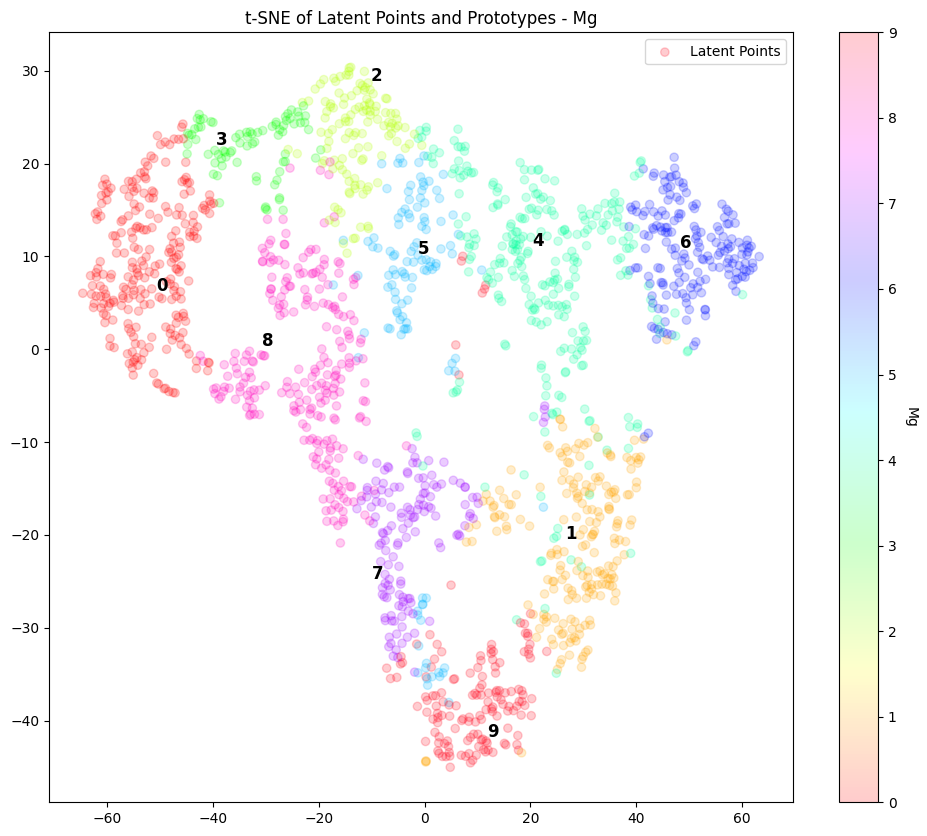

In [50]:

elemento = 'Mg'


# # # Plotar os resultados do t-SNE
# cluster_labels = train_gt[elemento]

# # clip cluster labels percentile
# lower_bound = np.percentile(cluster_labels, 5)
# upper_bound = np.percentile(cluster_labels, 95)
# cluster_labels = np.clip(cluster_labels, lower_bound, upper_bound)

plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.2)

# # # Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')


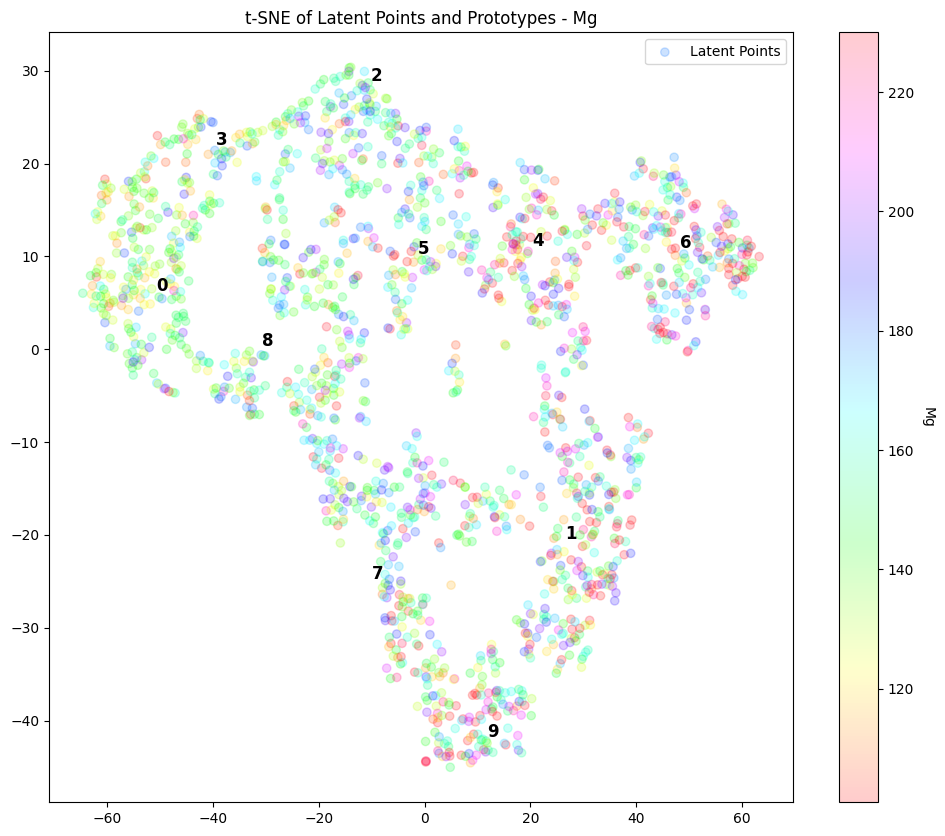

In [51]:



# # # Plotar os resultados do t-SNE
values = train_gt[elemento]

# clip cluster labels percentile
lower_bound = np.percentile(values, 5)
upper_bound = np.percentile(values, 95)
values = np.clip(values, lower_bound, upper_bound)

plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=values, cmap='hsv', label='Latent Points', alpha=0.2)

# # # Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')

Salvando a imagem em 'tsne_grid_2x2_hp1.png'


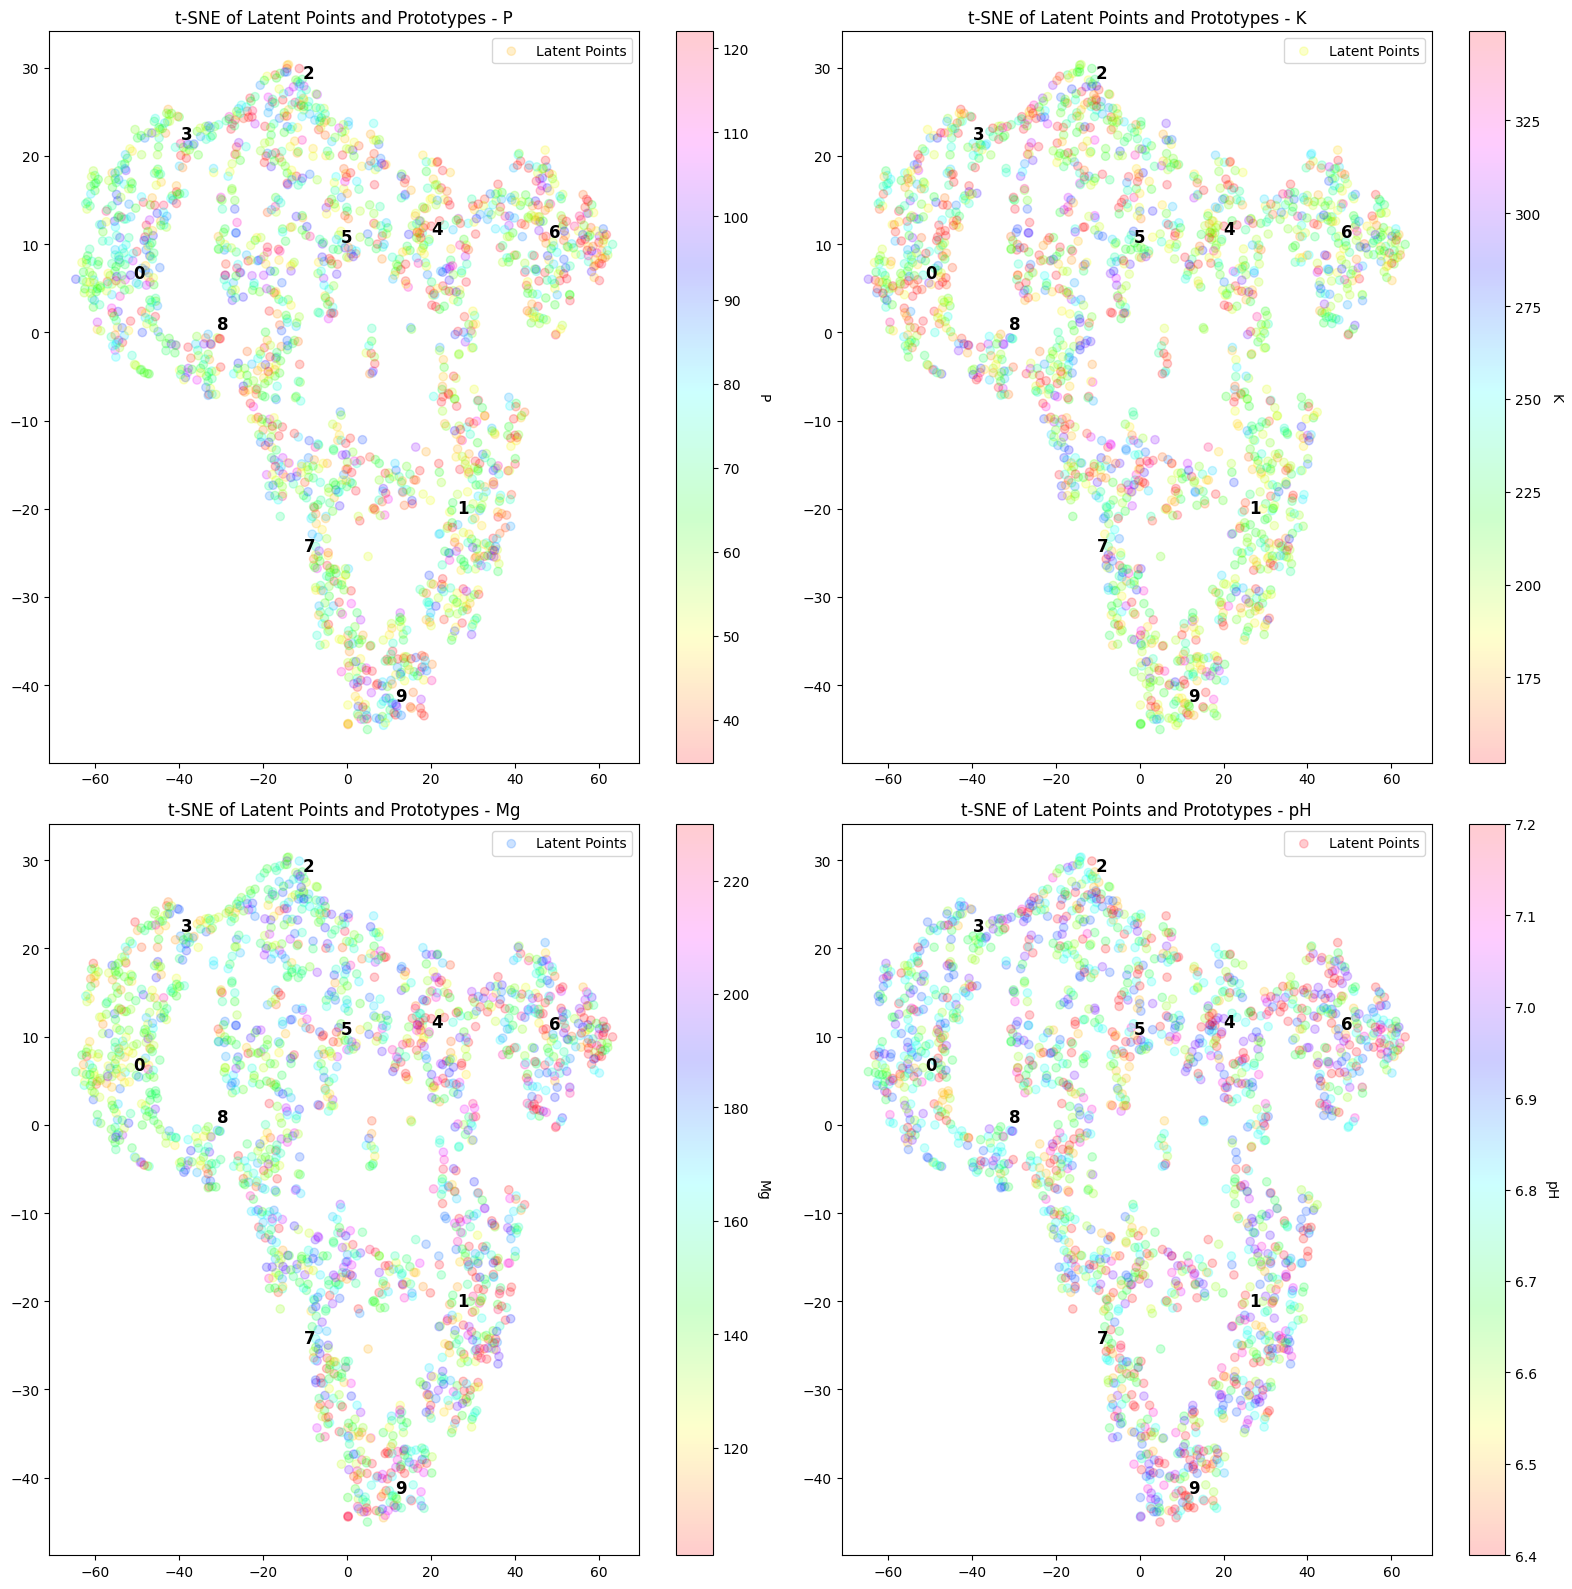

In [52]:




# 1. Lista de elementos que você quer plotar
elementos = ['P', 'K', 'Mg', 'pH']

# 2. Criar a grade de subplots (2 linhas, 2 colunas)
# Ajustei o figsize para (16, 16) para dar um bom espaço para cada plot (8x8)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# 3. "Achatar" o array de eixos (de 2x2 para 4x1) para facilitar o loop
# Isso transforma 'axes' de uma matriz 2D para um array 1D
axes = axes.flatten()

# 4. Loop pelos elementos e eixos correspondentes
# O 'zip' junta as duas listas: (axes[0], 'B'), (axes[1], 'Cu'), ...
for ax, elemento in zip(axes, elementos):
    
    # Obter os valores para o elemento atual
    values = train_gt[elemento]

    # Clipar os valores pelo percentil
    lower_bound = np.percentile(values, 5)
    upper_bound = np.percentile(values, 95)
    values = np.clip(values, lower_bound, upper_bound)

    # Plotar os resultados do t-SNE no eixo (ax) atual
    # Note que mudamos de 'plt.scatter' para 'ax.scatter'
    scatter = ax.scatter(
        tsne_E[:, 0], 
        tsne_E[:, 1], 
        c=values, 
        cmap='hsv', 
        label='Latent Points', 
        alpha=0.2
    )

    # Adicionar a barra de cores
    # Note que usamos fig.colorbar(..., ax=ax) para associar ao subplot correto
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(elemento, rotation=270, labelpad=15)

    # Adicionar os protótipos ao gráfico
    # Note que mudamos de 'plt.text' para 'ax.text'
    for i, (x, y) in enumerate(tsne_prot):
        ax.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

    # Definir título e legenda para o subplot específico
    ax.legend()
    ax.set_title(f"t-SNE of Latent Points and Prototypes - {elemento}")

# 5. Ajustar o layout para evitar sobreposição de títulos/rótulos
plt.tight_layout()

# 6. Salvar a figura inteira
print("Salvando a imagem em 'tsne_grid_2x2_hp1.png'")
plt.savefig("tsne_grid_2x2.png", dpi=150, bbox_inches='tight')

# plt.show() # Descomente se quiser exibir a imagem interativamente

/tmp/ipykernel_494590/1867182520.py:40: UserWarning: Adding colorbar to a different Figure <Figure size 1600x1600 with 8 Axes> than <Figure size 2400x1000 with 3 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter, ax=axes[1])


<Figure size 1200x2000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

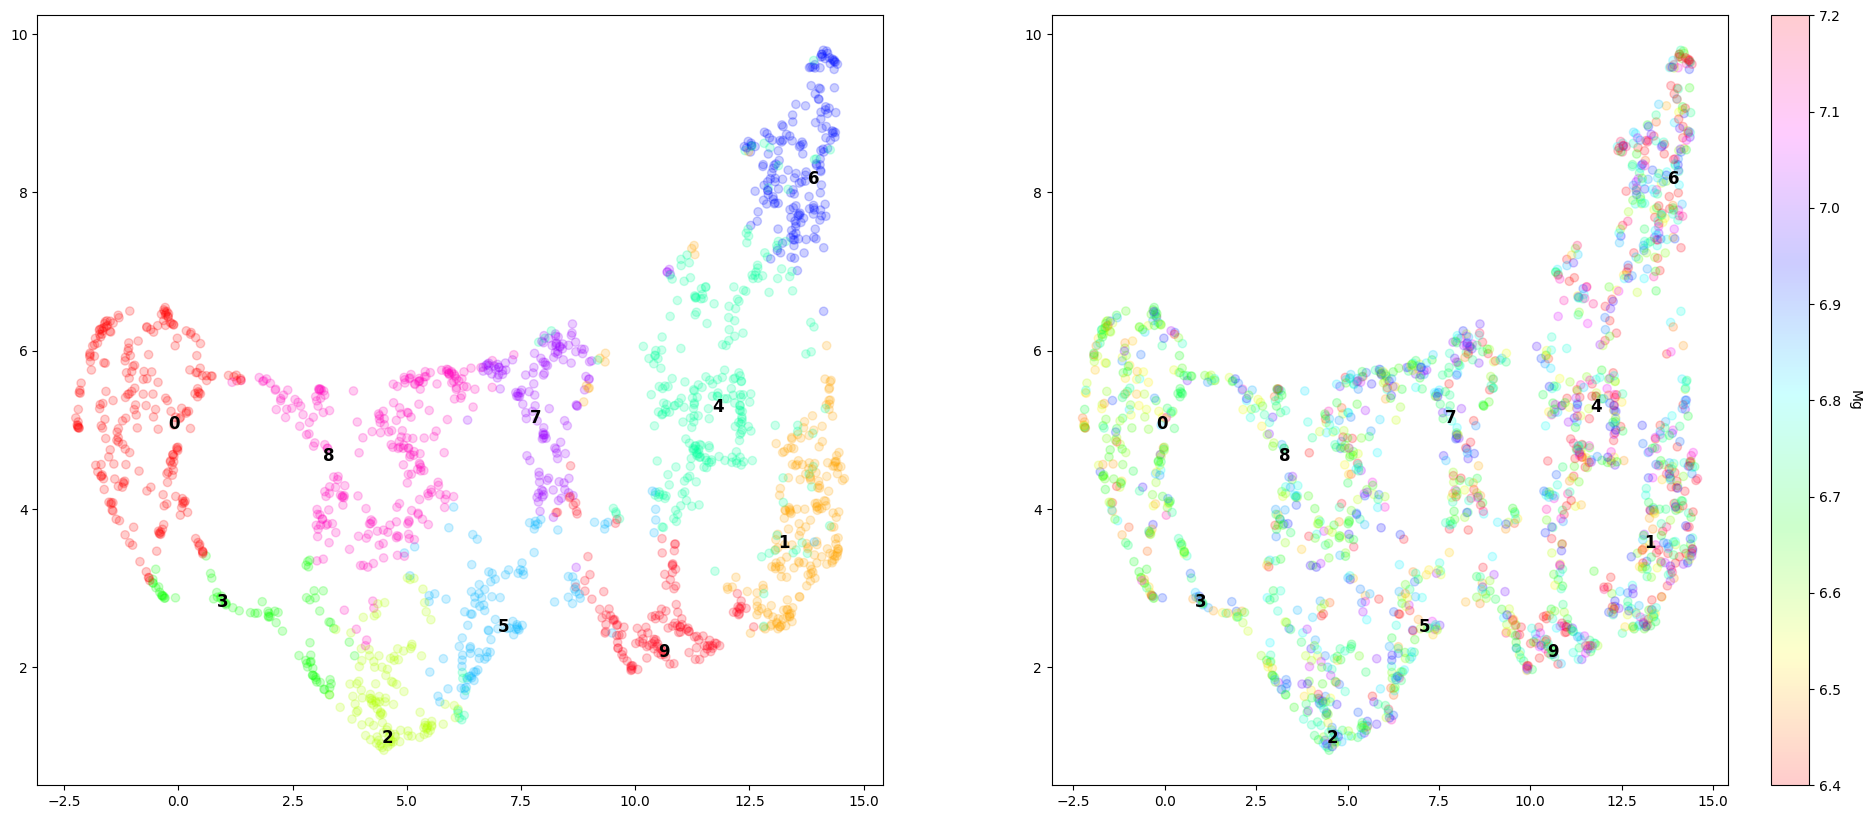

In [53]:

elemento = 'Mg'


# # Plotar os resultados do t-SNE
values = train_gt[elemento]

# clip cluster labels percentile
lower_bound = np.percentile(values, 5)
upper_bound = np.percentile(values, 95)
values = np.clip(values, lower_bound, upper_bound)




plt.figure(figsize=(12, 20))

# 2 plots 

# subplot 2 columns 1 row
plt.figure(figsize=(12, 10))


fig, axes = plt.subplots(1, 2, figsize=(24, 10))

axes[0].scatter(umap_E[:, 0], umap_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.2)

axes[1].scatter(umap_E[:, 0], umap_E[:, 1], c=values, cmap='hsv', label='Latent Points', alpha=0.2)






# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(umap_prot):
    axes[0].text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')
    axes[1].text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

# add cbar to axes[1]
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label(elemento, rotation=270, labelpad=15) # Adicion

# Salva a figura em um arquivo
plt.savefig('umap_plot.png')


In [54]:
# add cluster labels to train_gt dataframe
train_gt['cluster_label'] = cluster_labels

In [55]:
train_gt[train_gt['sample_index'] == 1344]['cluster_label'].value_counts()

cluster_label
3    1
Name: count, dtype: int64

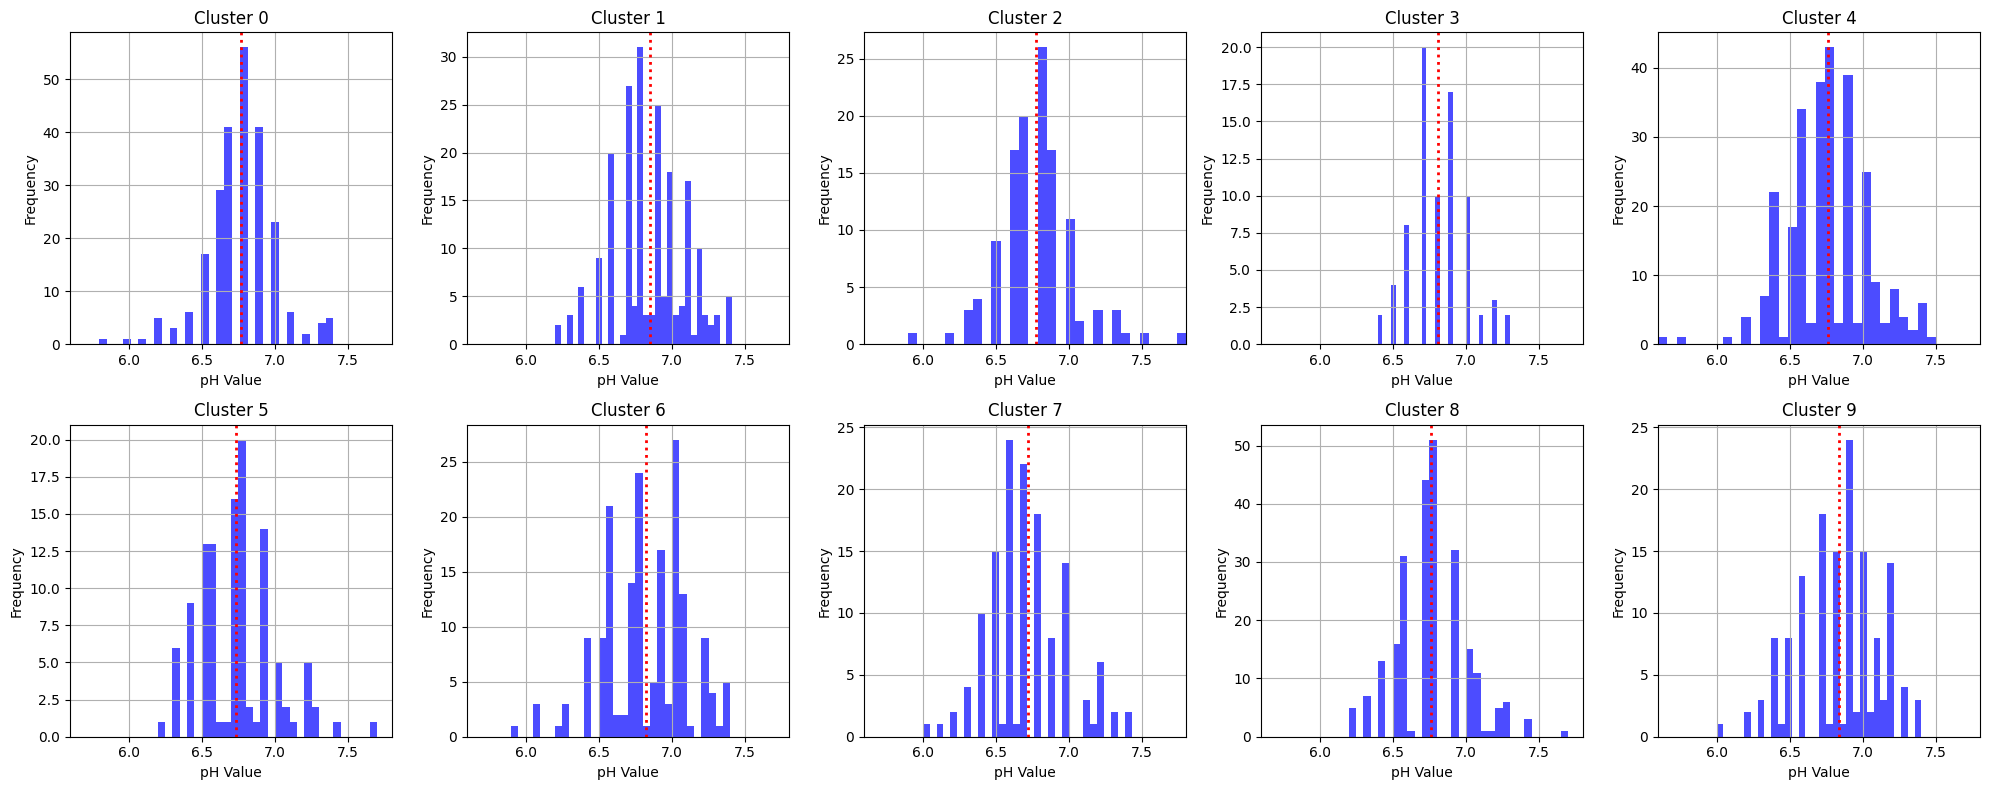

In [56]:
import matplotlib.pyplot as plt
import numpy as np # Importado para o ceil

elemento = 'pH'

# --- Suas definições (assumindo que 'train_gt' e 'elemento' existem) ---
cluster_limits = {'x_min': train_gt[elemento].min(), 'x_max': train_gt[elemento].max()}

# 1. Pegar TODOS os clusters únicos para plotar
all_clusters = sorted(train_gt['cluster_label'].unique())
num_clusters = len(all_clusters)

# 2. Definir o layout do grid
ncols = 5
nrows = int(np.ceil(num_clusters / ncols)) 

# 3. Criar a Figura e os Eixos (subplots) UMA ÚNICA VEZ
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))

# 4. "Achatar" (flatten) o array de eixos
axes_flat = axes.flatten()

# 5. Loop principal (iterando pelos clusters e eixos ao mesmo tempo)
for i, cluster_to_plot in enumerate(all_clusters):
    
    # Pega o eixo (subplot) atual
    ax = axes_flat[i]
    
    # Filtra os dados do cluster
    cluster_data = train_gt[train_gt['cluster_label'] == cluster_to_plot]

    # 6. Plotar DIRETAMENTE no eixo (ax)
    ax.hist(cluster_data[elemento], bins=30, color='blue', alpha=0.7)
    
    # --- NOVO TRECHO ADICIONADO ---
    # Calcular a média do cluster
    cluster_mean = cluster_data[elemento].mean()
    # Adicionar a linha da média (vermelha, pontilhada)
    ax.axvline(cluster_mean, color='red', linestyle='dotted', linewidth=2)
    # --- FIM DO NOVO TRECHO ---
    
    # 7. Usar os métodos 'set_' para configurar o eixo
    ax.set_title(f'Cluster {cluster_to_plot}')
    ax.set_xlabel(f'{elemento} Value', fontsize=10) 
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(True)
    
    # Definir os mesmos limites para todos os plots
    ax.set_xlim(cluster_limits['x_min'], cluster_limits['x_max'])

# 8. Desligar eixos extras
for j in range(num_clusters, nrows * ncols):
    axes_flat[j].axis('off')

# 9. Ajustar o layout
plt.tight_layout()

# 10. Mostrar a imagem inteira
plt.show()

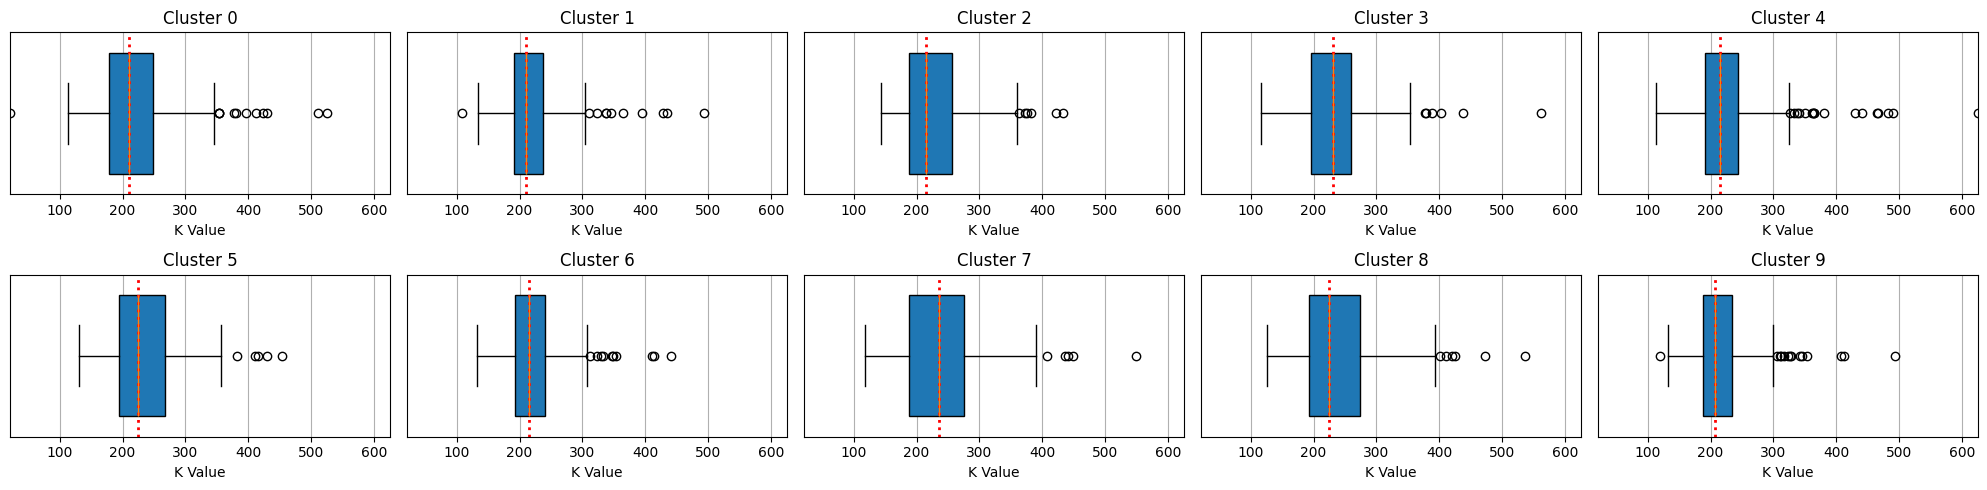

In [57]:
import matplotlib.pyplot as plt
import numpy as np

elemento = 'K'
# --- Suas definições (assumindo que 'train_gt' e 'elemento' existem) ---
cluster_limits = {'x_min': train_gt[elemento].min(), 'x_max': train_gt[elemento].max()}

# 1. Pegar TODOS os clusters únicos para plotar
all_clusters = sorted(train_gt['cluster_label'].unique())
num_clusters = len(all_clusters)

# 2. Definir o layout do grid
ncols = 5
nrows = int(np.ceil(num_clusters / ncols)) 

# 3. Criar a Figura e os Eixos (subplots) UMA ÚNICA VEZ
# Podemos diminuir a altura de cada linha, já que os boxplots serão mais finos
fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 2.5)) # altura reduzida de 3 para 2.5

# 4. "Achatar" (flatten) o array de eixos
axes_flat = axes.flatten()

# 5. Loop principal (iterando pelos clusters e eixos ao mesmo tempo)
for i, cluster_to_plot in enumerate(all_clusters):
    
    # Pega o eixo (subplot) atual
    ax = axes_flat[i]
    
    # Filtra os dados do cluster
    cluster_data = train_gt[train_gt['cluster_label'] == cluster_to_plot]

    # Plotar o boxplot na horizontal
    ax.boxplot(cluster_data[elemento], vert=False, patch_artist=True)
    
    # Calcular e plotar a linha da média
    cluster_mean = cluster_data[elemento].median()
    ax.axvline(cluster_mean, color='red', linestyle='dotted', linewidth=2)
    
    # --- LINHA ADICIONADA PARA DIMINUIR A ALTURA (YLIMIT) ---
    ax.set_ylim(0.9, 1.1) # Ajuste esses valores para obter a espessura desejada
    # -----------------------------------------------------------
    
    # Configurar os eixos
    ax.set_title(f'Cluster {cluster_to_plot}')
    ax.set_xlabel(f'{elemento} Value', fontsize=10) 
    ax.set_yticks([]) 
    ax.set_xlim(cluster_limits['x_min'], cluster_limits['x_max'])
    ax.grid(True, axis='x') 

# 8. Desligar eixos extras
for j in range(num_clusters, nrows * ncols):
    axes_flat[j].axis('off')

# 9. Ajustar o layout
plt.tight_layout()

# 10. Mostrar a imagem inteira
plt.show()

In [58]:
train_gt['sample_index'].nunique()

1732

In [59]:
sample_idx = train_gt['sample_index'].nunique()

np.random.seed(2)
train_indices = np.random.choice(sample_idx, size=int(0.8 * sample_idx), replace=False)
val_indices = np.setdiff1d(np.arange(sample_idx), train_indices)

X_train_index = train_gt[train_gt['sample_index'].isin(train_indices)].index
X_val_index   = train_gt[train_gt['sample_index'].isin(val_indices)].index



# target element for regression

elemento = "K"

# numpy views of embeddings and target
E_numpy = E.cpu().numpy()
y_numpy = train_gt[elemento].values

# split arrays
E_train = E_numpy[X_train_index]
E_val = E_numpy[X_val_index]
y_train = y_numpy[X_train_index]
y_val = y_numpy[X_val_index]


In [60]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np



# 3. Criar e treinar o modelo XGBoost
# Não precisa se preocupar com device, batches, ou normalização
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', # Equivalente ao MSELoss
    n_estimators=100,             # Número de "árvores" (similar às épocas)
    learning_rate=0.05,
    max_depth=4,
    early_stopping_rounds=50,      # Para de treinar se a validação não melhorar
    n_jobs=-1                      # Usar todos os cores da CPU
)

print("Training XGBoost...")
model_xgb.fit(
    E_train, 
    y_train,
    eval_set=[(E_val, y_val)], # Usa o conjunto de validação para early stopping
    verbose=100                # Imprime o erro a cada 100 rodadas
)

# 4. Avaliar o modelo
preds = model_xgb.predict(E_val)
mse = mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)
print(f"Validation R2: {r2:.4f}")
print(f"Validation MSE: {mse:.4f}")


Training XGBoost...
[0]	validation_0-rmse:63.87015
[53]	validation_0-rmse:64.63690
Validation R2: 0.0050
Validation MSE: 4066.9183


In [61]:
downstream_folder = os.path.join('downstream' )
os.makedirs(downstream_folder, exist_ok=True)
downstream_folder_model = os.path.join(downstream_folder, model_folder)
os.makedirs(downstream_folder_model, exist_ok=True)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# -------------------------------------------------------
# ELEMENTOS
# -------------------------------------------------------
elementos = ['P', 'K', 'Mg', 'pH']

# -------------------------------------------------------
# SPLIT baseado no sample_index
# -------------------------------------------------------
sample_idx = train_gt['sample_index'].nunique()

np.random.seed(42)
train_indices = np.random.choice(sample_idx, size=int(0.8 * sample_idx), replace=False)
val_indices = np.setdiff1d(np.arange(sample_idx), train_indices)

X_train_index = train_gt[train_gt['sample_index'].isin(train_indices)].index
X_val_index   = train_gt[train_gt['sample_index'].isin(val_indices)].index

# embeddings (numpy)
E_numpy = E.cpu().numpy()

# -------------------------------------------------------
# RESULTADOS
# -------------------------------------------------------
results = []

# -------------------------------------------------------
# LOOP DOS 6 ELEMENTOS
# -------------------------------------------------------
for elemento in elementos:
    print(f"\nTreinando XGBoost para {elemento}...")

    # targets
    y_numpy = train_gt[elemento].values
    y_train = y_numpy[X_train_index]
    y_val   = y_numpy[X_val_index]

    # inputs
    E_train = E_numpy[X_train_index]
    E_val   = E_numpy[X_val_index]

    # modelo
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        n_jobs=-1
    )

    model.fit(
        E_train, y_train,
        eval_set=[(E_val, y_val)],
        verbose=False
    )

    preds = model.predict(E_val)

    r2  = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)
    rmse = mean_squared_error(y_val, preds)

    results.append([elemento, r2, mae, rmse])

# -------------------------------------------------------
# TABELA DE RESULTADOS
# -------------------------------------------------------
import pandas as pd
df_results = pd.DataFrame(results, columns=["Elemento", "R2", "MAE", "MSE"])
print("\n================ RESULTADOS =================")
print(df_results)


# save results to csv in downstream_folder_model
df_results.to_csv(downstream_folder_model + "/xgboost_results.csv", index=False)

# -------------------------------------------------------
# FIGURA COM 6 SUBPLOTS
# -------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, elemento in enumerate(elementos):
    ax = axes[i]

    # re-executar target/pred para o plot
    y_numpy = train_gt[elemento].values
    y_train = y_numpy[X_train_index]
    y_val   = y_numpy[X_val_index]
    E_train = E_numpy[X_train_index]
    E_val   = E_numpy[X_val_index]

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        n_jobs=-1
    )
    model.fit(E_train, y_train, eval_set=[(E_val, y_val)], verbose=False)
    preds = model.predict(E_val)

    # plot
    ax.scatter(y_val, preds, alpha=0.5)
    lim_min = min(y_val.min(), preds.min())
    lim_max = max(y_val.max(), preds.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--')

    ax.set_title(f"{elemento}")
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")

plt.tight_layout()
plt.savefig(downstream_folder_model + "/xgboost_scatter_plots.png", dpi=150, bbox_inches='tight')
plt.close(fig)


Treinando XGBoost para P...

Treinando XGBoost para K...

Treinando XGBoost para Mg...

Treinando XGBoost para pH...

================ RESULTADOS =================
  Elemento        R2        MAE          MSE
0        P -0.008018  20.253563   794.155634
1        K -0.033293  41.443737  2978.718476
2       Mg  0.017067  31.374250  1716.241296
3       pH  0.000180   0.195335     0.069083
